# Comparison of the effectiveness of ensemble regression and simple regression models for air pollution data

Data source: https://www.kaggle.com/datasets/fedesoriano/air-quality-data-set

*Authors:*
- *Mateusz Smigielski*
- *Jakub Kudryk*



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
import scipy.stats as stats
from statistics import mean 

In [2]:
df = pd.read_csv("AirQuality.csv",sep=";", decimal=",",header=0)
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')

In [3]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


## Data preprocessing

In [4]:
dropped = df.drop(["NMHC(GT)", "Unnamed: 15", "Unnamed: 16", "C6H6(GT)", "NOx(GT)", "RH", "Date", "NO2(GT)", "Time"], axis=1)

In [5]:
dropped.head()

,CO(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,AH
0,2.6,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,0.7578
1,2.0,1292.0,955.0,1174.0,1559.0,972.0,13.3,0.7255
2,2.2,1402.0,939.0,1140.0,1555.0,1074.0,11.9,0.7502
3,2.2,1376.0,948.0,1092.0,1584.0,1203.0,11.0,0.7867
4,1.6,1272.0,836.0,1205.0,1490.0,1110.0,11.2,0.7888


Delete rows with NaN values

In [6]:
dropped.isna().sum()

CO(GT)           114
PT08.S1(CO)      114
PT08.S2(NMHC)    114
PT08.S3(NOx)     114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
AH               114
dtype: int64

In [7]:
dropped.dropna(inplace=True)
dropped.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
       'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'AH'],
      dtype='object')

Averaging -200 values

Text(0.5, 1.0, 'Value map -200')

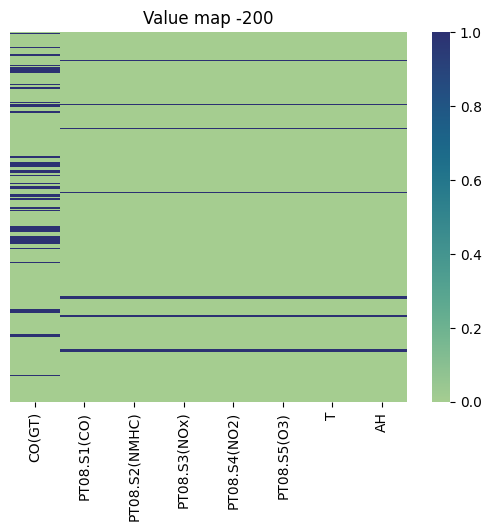

In [8]:
ax = plt.axes()
sns.heatmap(dropped==-200,yticklabels=False,cmap='crest', ax = ax)
ax.set_title('Value map -200')

In [9]:
dropped.replace(to_replace=-200,value=np.nan,inplace=True)
#columns_tmp = dropped.drop(["Time"], axis=1)
for i in dropped:
    dropped[i] = dropped[i].fillna(dropped[i].mean())

In [10]:
#ax = plt.axes()
#sns.heatmap(dropped==-200,yticklabels=False,cmap='crest', ax = ax)
#ax.set_title('Mapa wartości -200 po uśrednieniu')

In [11]:
dropped.head()

,CO(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,AH
0,2.6,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,0.7578
1,2.0,1292.0,955.0,1174.0,1559.0,972.0,13.3,0.7255
2,2.2,1402.0,939.0,1140.0,1555.0,1074.0,11.9,0.7502
3,2.2,1376.0,948.0,1092.0,1584.0,1203.0,11.0,0.7867
4,1.6,1272.0,836.0,1205.0,1490.0,1110.0,11.2,0.7888


### Correlation matrix

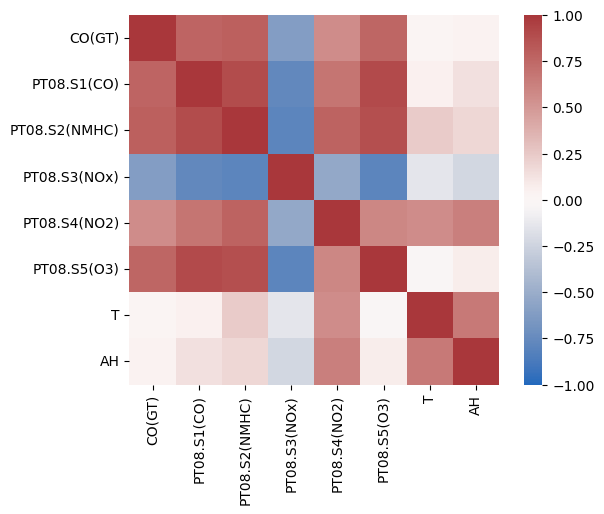

,CO(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,AH
CO(GT),1.000000,0.773394,0.795578,-0.613877,0.558232,0.759027,0.020257,0.043274
PT08.S1(CO),0.773394,1.000000,0.892964,-0.771938,0.682881,0.899324,0.048627,0.135324
PT08.S2(NMHC),0.795578,0.892964,1.000000,-0.796703,0.777254,0.880578,0.241373,0.186933
PT08.S3(NOx),-0.613877,-0.771938,-0.796703,1.000000,-0.538468,-0.796569,-0.145112,-0.232017
PT08.S4(NO2),0.558232,0.682881,0.777254,-0.538468,1.000000,0.591144,0.561270,0.629641
PT08.S5(O3),0.759027,0.899324,0.880578,-0.796569,0.591144,1.000000,-0.027172,0.070751
T,0.020257,0.048627,0.241373,-0.145112,0.561270,-0.027172,1.000000,0.656397
AH,0.043274,0.135324,0.186933,-0.232017,0.629641,0.070751,0.656397,1.000000


In [12]:
dropped_corr = dropped.corr()

axis_corr = sns.heatmap(
dropped_corr,
vmin=-1, vmax=1, center=0,
cmap="vlag",
square=True
)

plt.show()
dropped_corr

## Simple regression models

In [13]:
msetable = {
    "LinearRegression"             : None,
    "DecisionTreeRegressor_depth1" : None,
    "DecisionTreeRegressor_depth2" : None,
    "DecisionTreeRegressor_depth3" : None,
    "DecisionTreeRegressor_depth4" : None,
    "DecisionTreeRegressor_depth5" : None,
    "DecisionTreeRegressor_depth6" : None,
    "DecisionTreeRegressor_depth7" : None,
    "DecisionTreeRegressor_depth8" : None,
    "DecisionTreeRegressor_depth9" : None,
    "DecisionTreeRegressor_depth10": None,
    "BaggingRegressor"             : None,
    "GradientBoostingRegressor"    : None
    }

In [14]:
def kFold_train_test_model(model, X, y, n_splits=10, random_state=42):
    mse_list=[]
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        mse_fold = mean_squared_error(y_test, y_predict)
        mse_list.append(mse_fold)
    return mse_list

In [15]:
attributes = ['PT08.S3(NOx)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'AH']
label = 'CO(GT)'
models = msetable.keys()

### Linear regression

In [16]:
features = list(set(attributes) - set(label))
X = np.array(dropped[features])
y = np.array(dropped[label]).reshape(-1, 1)

lrmodel = LinearRegression()
msetable["LinearRegression"] = kFold_train_test_model(lrmodel, X, y)

### Decision tree regressor

In [17]:
features = list(set(attributes) - set(label))
X = np.array(dropped[features])
y = np.array(dropped[label]).reshape(-1, 1)
for maxdepth in range(1,11):
    dcregressor = DecisionTreeRegressor(max_depth=maxdepth)  
    msetable[f"DecisionTreeRegressor_depth{maxdepth}"] = kFold_train_test_model(dcregressor, X, y)

## Ensemble regression

### Gradient Boosting Regressor

In [18]:
features = list(set(attributes) - set(label))
X = np.array(dropped[features])
y = np.array(dropped[label]).reshape(-1, 1).ravel()

gbrmodel = GradientBoostingRegressor() 
msetable["GradientBoostingRegressor"] = kFold_train_test_model(gbrmodel, X, y)

### Bagging Regressor

In [19]:
features = list(set(attributes) - set(label))
X = np.array(dropped[features])
y = np.array(dropped[label]).reshape(-1, 1).ravel()

brmodel = BaggingRegressor()
msetable["BaggingRegressor"] = kFold_train_test_model(brmodel, X, y)

## Comparative analysis

### Mean squared error histograms

In [20]:
def plot_histograms_for_all_models():
    ncols = 4
    keys = models
    nrows = (len(keys) + ncols - 1)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(35, 120))
    axes = axes.flatten()
    
    for i, (key, value) in enumerate(msetable.items()):
        ax = axes[i]
        ax.hist(value, bins=10)
        ax.set_title(key)
        ax.set_xlabel("MSE values")
        ax.set_ylabel("MSE value instances per bin")
    
    for j in range(len(keys), len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

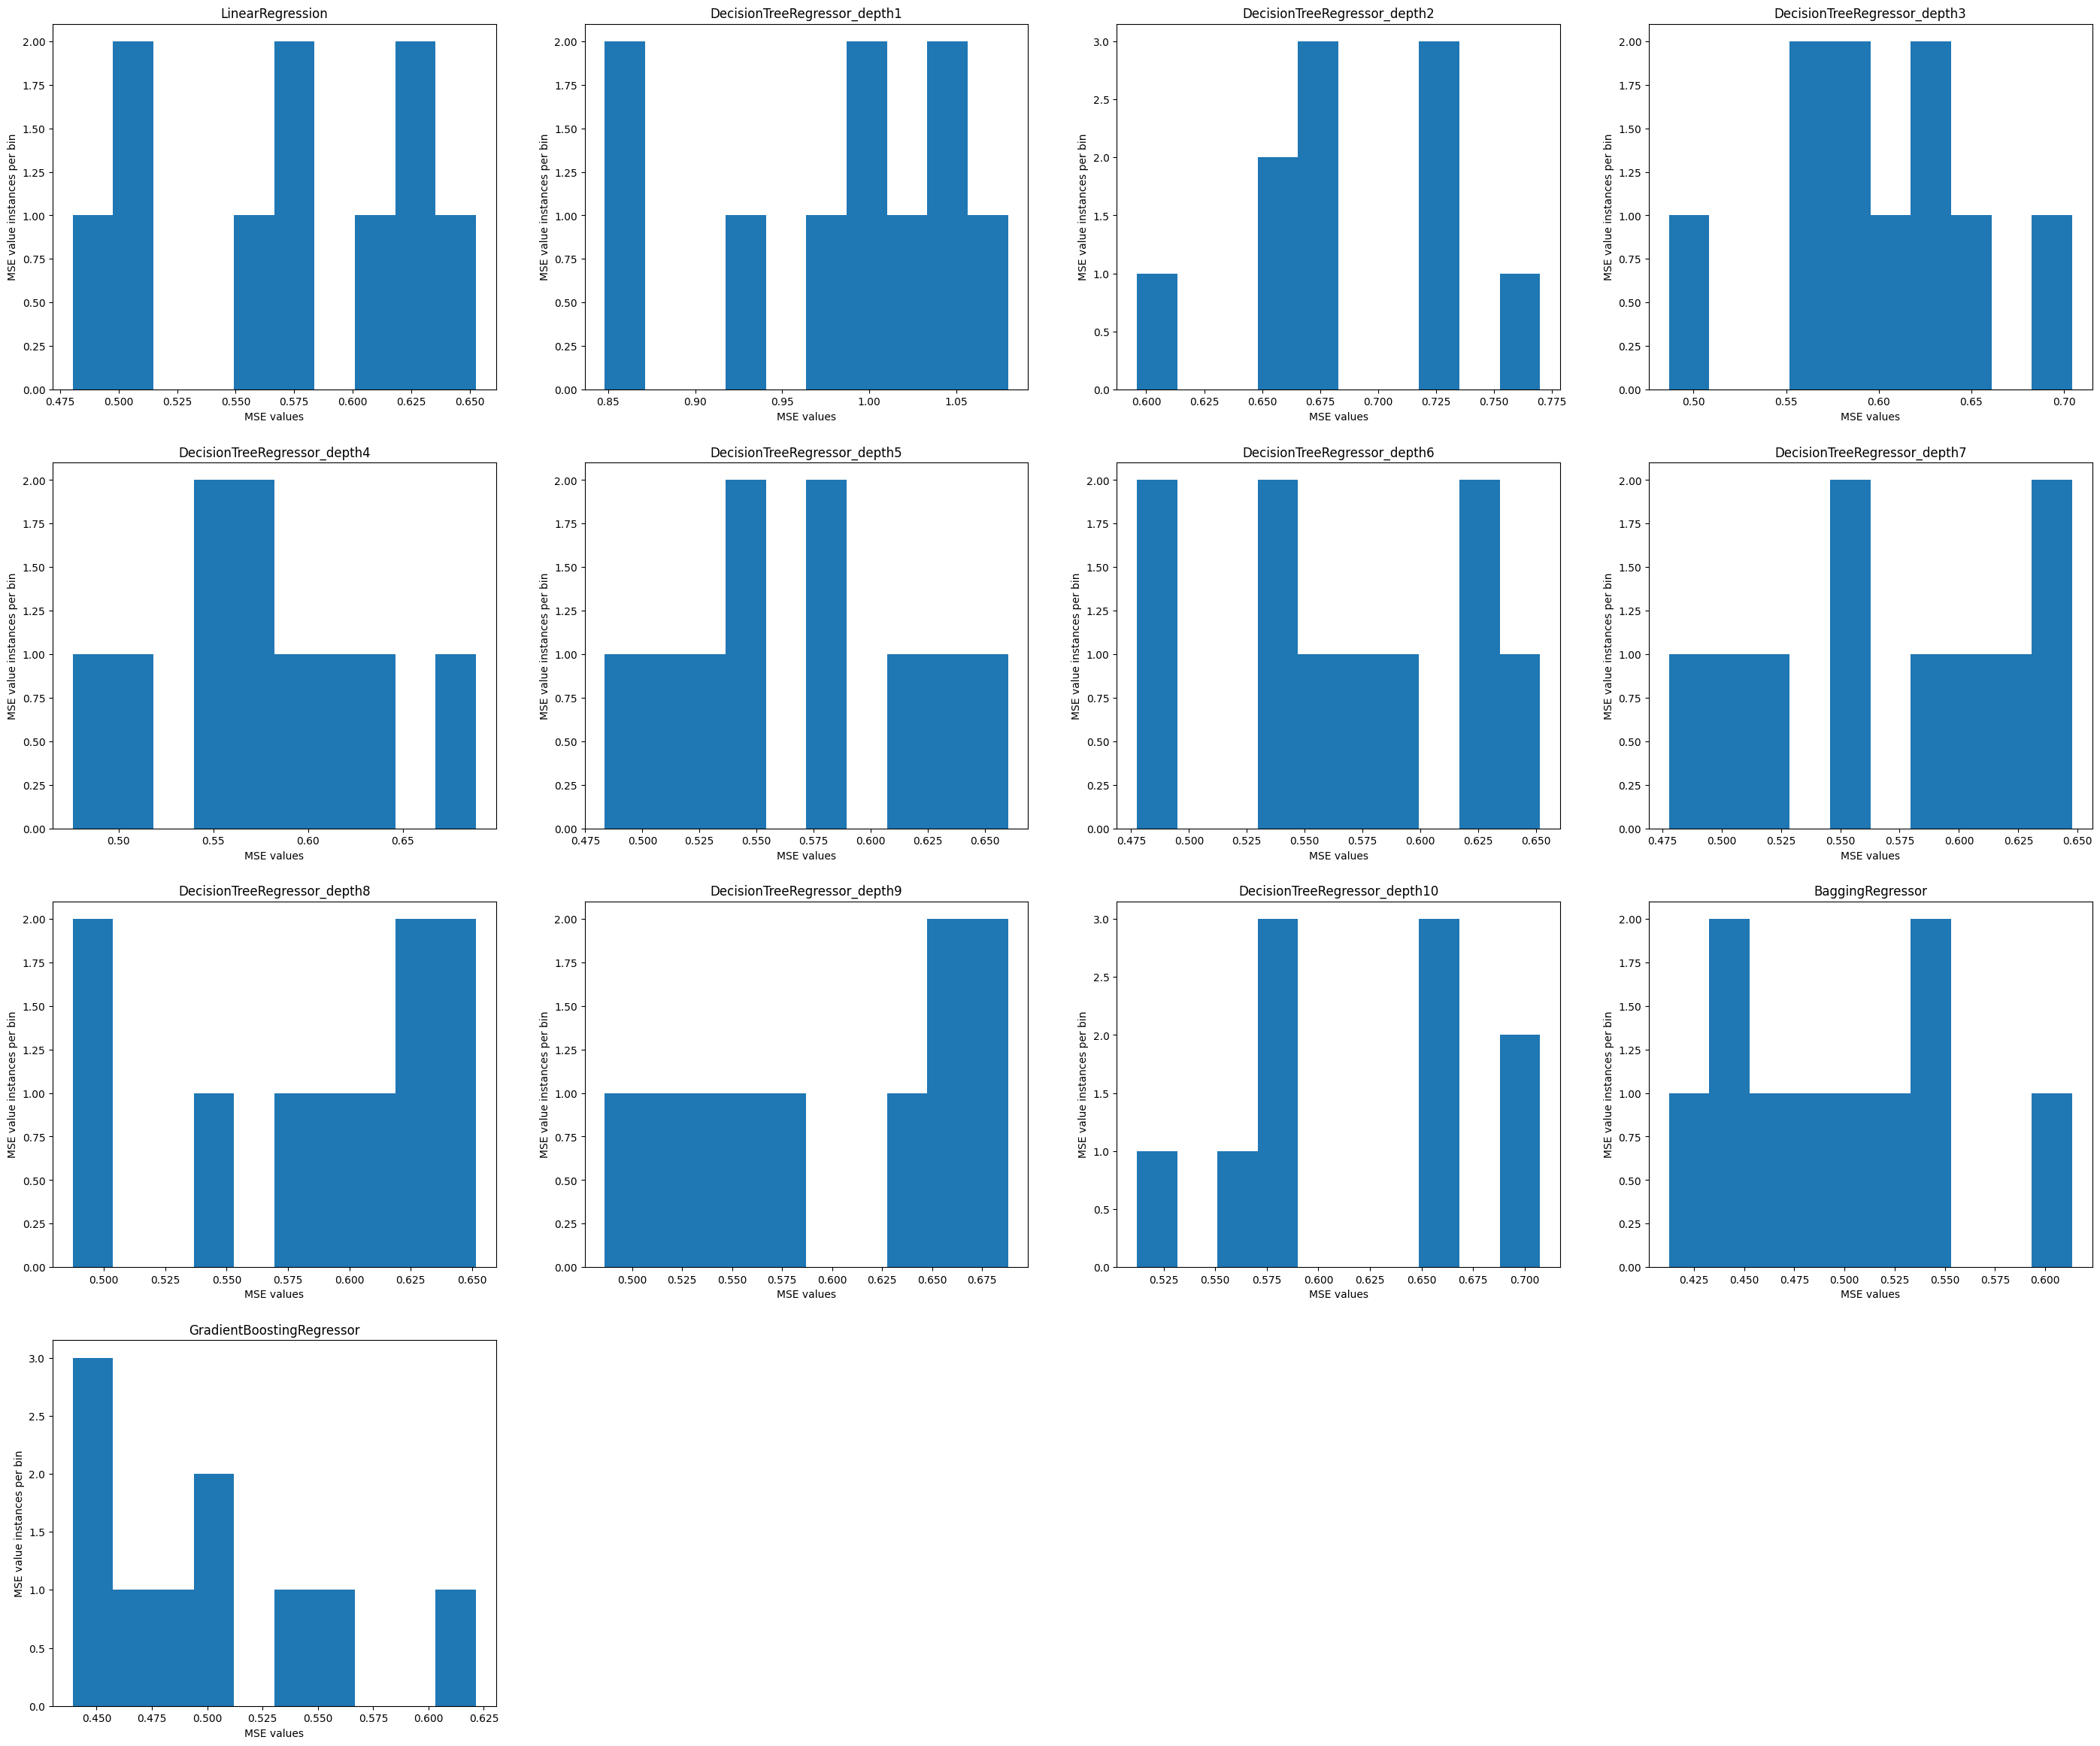

In [21]:
plot_histograms_for_all_models()

Although histograms can show that data normality assumption has not been met, the data sample is too small to claim that, so we use K-Fold CV Paired t Test to compare models.

### K-Fold CV Paired t Test

In [22]:
def create_models_comparison_matrix(p_msetable):
    comparison_matrix = [[-1 for _ in range(len(p_msetable))] for _ in range(len(p_msetable))]
    statistical_significance = 0.05
    
    for i, model1 in enumerate(p_msetable):
        for j, model2 in enumerate(p_msetable):
            pvalue = stats.ttest_rel(p_msetable[model1], p_msetable[model2]).pvalue
            mean1 = mean(p_msetable[model1])
            mean2 = mean(p_msetable[model2])
            is_statistically_significant = pvalue < 0.05
    
            if is_statistically_significant:
                comparison_matrix[i][j] = 0 if mean1 < mean2 else 1
    
    return comparison_matrix

In [23]:
from matplotlib.colors import LinearSegmentedColormap

def plot_models_comparison_matrix(comparison_matrix):
    models_labels = models
    
    
    myColors = ((1.0, 1.0, 1.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.8, 0.0, 0.0, 1.0))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    
    comparison_map = sns.heatmap(
    comparison_matrix,
    xticklabels=models_labels, 
    yticklabels=models_labels,
    cmap=cmap,
    linewidths=1, 
    linecolor='black',
    square=True
    )
    
    colorbar = comparison_map.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    colorbar.set_ticklabels(['No statistical difference', 'Y better than X', 'X better than Y'])
    
    comparison_map.set_ylabel('Y')
    comparison_map.set_xlabel('X')
    
    plt.title('Models comparison matrix')
    plt.show()

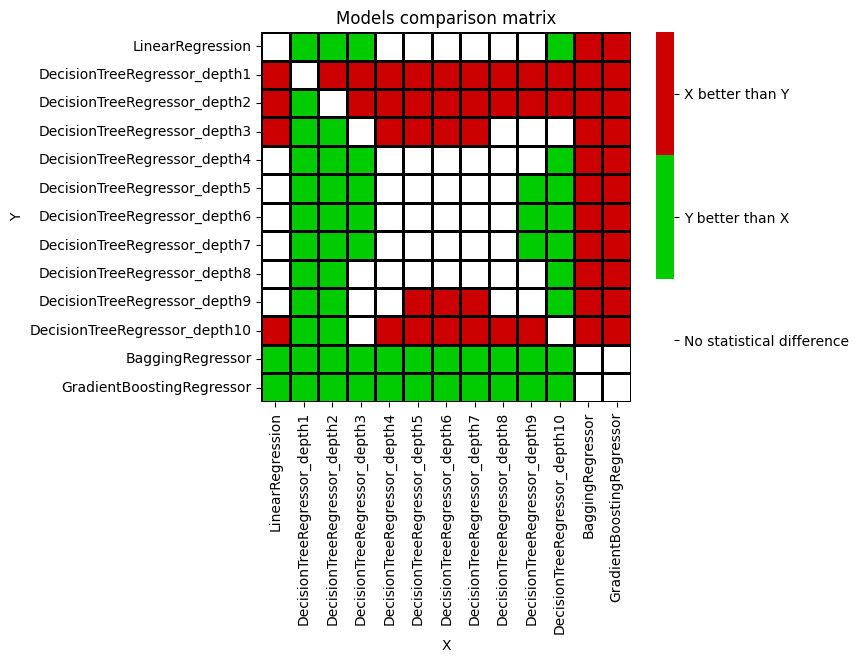

In [24]:
plot_models_comparison_matrix(create_models_comparison_matrix(msetable))